# Multiclass Example

This example show shows how to use `tsfresh` to extract and select useful features from timeseries in a multiclass classification example. 
The underlying control of the false discovery rate (FDR) has been introduced by [Tang et al. (2020, Sec. 3.2)](https://doi.org/10.1140/epjds/s13688-020-00244-9).

We use an example dataset of human activity recognition for this.
The dataset consists of timeseries for 7352 accelerometer readings. 
Each reading represents an accelerometer reading for 2.56 sec at 50hz (for a total of 128 samples per reading). Furthermore, each reading corresponds one of six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying).

For more information go to https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

This notebook follows the example in [the first notebook](./01%20Feature%20Extraction%20and%20Selection.ipynb), so we will go quickly over the extraction and focus on the more interesting feature selection in this case.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np

## Load and visualize data

In [2]:
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes

# fetch dataset from uci
download_har_dataset()

In [3]:
df = load_har_dataset()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.388873,0.618763,0.774067,0.586568,0.217007,-0.027330,-0.171294,-0.218988,-0.137680,0.033094,...,-0.227949,-0.247119,-0.227710,-0.210942,-0.179295,-0.142085,-0.131831,-0.154000,-0.176886,-0.211068
7348,0.711864,0.709237,0.321368,-0.028921,-0.208107,-0.192802,-0.066754,-0.042285,0.058089,0.106855,...,-0.311864,-0.316281,-0.274100,-0.326159,-0.379539,-0.382544,-0.371156,-0.295357,-0.203831,-0.124548
7349,-0.226717,-0.177817,-0.150869,-0.132237,-0.068338,0.007874,0.096481,0.205834,0.441342,0.662930,...,-0.177051,-0.248426,-0.313892,-0.367070,-0.395135,-0.347338,-0.319902,-0.294935,-0.243403,-0.215215
7350,-0.064806,-0.079933,-0.068350,-0.038477,-0.028679,0.018335,0.077571,0.253580,0.507805,0.583999,...,-0.240819,-0.330930,-0.396854,-0.413906,-0.379085,-0.356609,-0.317618,-0.315016,-0.330737,-0.272348


In [5]:
y = load_har_classes()
y

0       5
1       5
2       5
3       5
4       5
       ..
7347    2
7348    2
7349    2
7350    2
7351    2
Name: 0, Length: 7352, dtype: int64

The data is not in a typical time series format so far: 
the columns are the time steps whereas each row is a measurement of a different person.

Therefore we bring it to a format where the time series of different persons are identified by an `id` and are order by time vertically.

In [6]:
df["id"] = df.index
df = df.melt(id_vars="id", var_name="time").sort_values(["id", "time"]).reset_index(drop=True)

In [7]:
df.head()

,id,time,value
0,0,0,0.000181
1,0,1,0.010139
2,0,2,0.009276
3,0,3,0.005066
4,0,4,0.010810


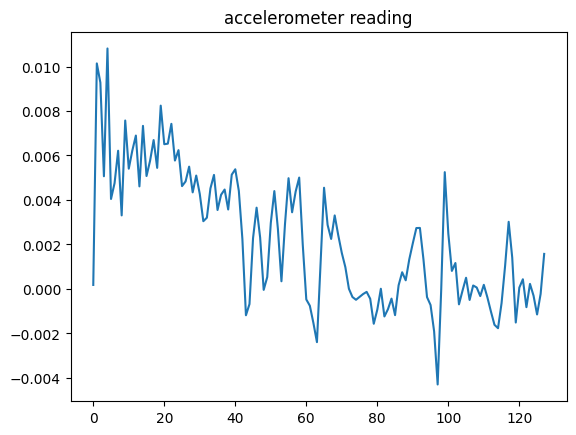

In [8]:
plt.title('accelerometer reading')
plt.plot(df[df["id"] == 0].set_index("time").value)
plt.show()

## Extract Features

In [9]:
# only use the first 500 ids to speed up the processing
X = extract_features(df[df["id"] < 500], column_id="id", column_sort="time", impute_function=impute)

Feature Extraction: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


In [10]:
X.head()

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,0.290392,0.001766,0.001435,0.000011,-0.000032,0.002025,...,0.079487,0.419383,2.000401,1.747535,3.015811,4.068979,4.555721,4.724480,0.0,0.008684
1,0.0,0.0,0.0,0.0,0.022239,0.000506,0.001323,-0.000021,-0.000008,0.000110,...,0.891060,1.336251,3.019874,1.706146,2.903657,3.936212,4.520418,4.747206,0.0,0.005250
2,0.0,0.0,0.0,0.0,0.054796,0.001106,0.001827,-0.000011,0.000001,0.000627,...,0.948691,1.397948,2.576279,1.669552,2.772489,3.784472,4.409911,4.735843,0.0,0.007916
3,0.0,0.0,0.0,0.0,0.042157,0.000932,0.001470,0.000014,0.000003,0.000269,...,0.600197,1.022235,2.654834,1.638109,2.654572,3.644889,4.335833,4.686101,0.0,0.007687
4,0.0,0.0,0.0,0.0,-0.024980,0.000525,0.001215,-0.000027,-0.000007,-0.000144,...,0.866293,1.327997,2.760333,1.637482,2.680036,3.652981,4.350795,4.656301,0.0,0.004961


## Train and evaluate classifier

For later comparison, we train a decision tree on all features (without selection):

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y[:500], test_size=.2)

In [12]:
classifier_full = DecisionTreeClassifier()
classifier_full.fit(X_train, y_train)
print(classification_report(y_test, classifier_full.predict(X_test)))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98        24
           2       1.00      1.00      1.00        13
           3       0.94      1.00      0.97        15
           4       0.57      0.75      0.65        16
           5       0.53      0.57      0.55        14
           6       0.50      0.33      0.40        18

    accuracy                           0.77       100
   macro avg       0.76      0.77      0.76       100
weighted avg       0.77      0.77      0.76       100



# Multiclass feature selection

We will now select a subset of relevant features using the `tsfresh` select features method.
However it only works for binary classification or regression tasks. 

For a 6 label multi classification we therefore split the selection problem into 6 binary one-versus all classification problems. 
For each of them we can do a binary classification feature selection:

In [13]:
relevant_features = set()

for label in y.unique():
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train, y_train_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

Number of relevant features for class 5: 241/783
Number of relevant features for class 4: 218/783
Number of relevant features for class 6: 204/783
Number of relevant features for class 1: 239/783
Number of relevant features for class 3: 243/783
Number of relevant features for class 2: 197/783


In [14]:
len(relevant_features)

303

we keep only those features that we selected above, for both the train and test set

In [15]:
X_train_filtered = X_train[list(relevant_features)]
X_test_filtered = X_test[list(relevant_features)]

and train again:

In [16]:
classifier_selected = DecisionTreeClassifier()
classifier_selected.fit(X_train_filtered, y_train)
print(classification_report(y_test, classifier_selected.predict(X_test_filtered)))

              precision    recall  f1-score   support

           1       1.00      0.92      0.96        24
           2       0.93      1.00      0.96        13
           3       0.94      1.00      0.97        15
           4       0.43      0.56      0.49        16
           5       0.69      0.64      0.67        14
           6       0.50      0.39      0.44        18

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.76      0.75      0.75       100



It worked! The precision improved by removing irrelevant features.

## Improved Multiclass feature selection
We can instead specify the number of classes for which a feature should be a relevant predictor in order to pass through the filtering process. This is as simple as setting the `multiclass` parameter to `True` and setting `n_significant` to the required number of classes. We will try with a requirement of being relevant for 5 classes.

In [17]:
X_train_filtered_multi = select_features(X_train, y_train, multiclass=True, n_significant=5)
X_train_filtered_multi.shape

(400, 189)

We can see that the number of relevant features is lower than the previous implementation.

In [18]:
classifier_selected_multi = DecisionTreeClassifier()
classifier_selected_multi.fit(X_train_filtered_multi, y_train)
X_test_filtered_multi = X_test[X_train_filtered_multi.columns]
print(classification_report(y_test, classifier_selected_multi.predict(X_test_filtered_multi)))

              precision    recall  f1-score   support

           1       0.96      0.96      0.96        24
           2       0.92      0.92      0.92        13
           3       1.00      1.00      1.00        15
           4       0.40      0.50      0.44        16
           5       0.47      0.64      0.55        14
           6       0.67      0.33      0.44        18

    accuracy                           0.73       100
   macro avg       0.74      0.73      0.72       100
weighted avg       0.75      0.73      0.73       100



We now get slightly better classification performance, especially for classes where the previous classifier performed poorly. The parameter `n_significant` can be tuned for best results.